In [1]:
import os
import numpy as np
import pandas as pd
idx = pd.IndexSlice

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
colors = sns.color_palette()

import joblib
import statsmodels.api as sm
SEED = 69

from utils import abcd, preprocess
ABCD_PATH = '../../ABCD'

In [2]:
fcon, fc_extra = abcd.load_data(ABCD_PATH, 'fcon', dropna=True, include_rec=True, exclude_n=True)
scon, sc_extra = abcd.load_data(ABCD_PATH, 'scon', dropna=True, include_rec=True)

subs = fcon.index.intersection(scon.index).get_level_values(0).unique()
print(len(subs), 'subjects')

fcon = fcon.loc[subs]
scon = scon.loc[subs]

3925 subjects


In [3]:
covariates = abcd.load_covariates('output/abcd_covariates.csv', simple_race=True)

# Preprocess

## Split replication sample

In [4]:
family = covariates.loc[idx[subs, abcd.EVENTS[0]], 'rel_family_id'].droplevel('eventname')

In [5]:
from sklearn.model_selection import GroupShuffleSplit

gss = GroupShuffleSplit(n_splits=1, test_size=.2, random_state=SEED)
disc, repl = next(gss.split(subs, groups=family))

In [6]:
fc, fc_repl = fcon.loc[subs[disc]], fcon.loc[subs[repl]]
sc, sc_repl = scon.loc[subs[disc]], scon.loc[subs[repl]]

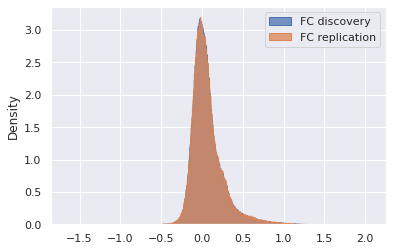

In [7]:
sns.histplot(fc.to_numpy().ravel(), label='FC discovery',
             stat='density', element='step', color=colors[0])
sns.histplot(fc_repl.to_numpy().ravel(), label='FC replication',
             stat='density', element='step', color=colors[1])
plt.legend()

plt.show()

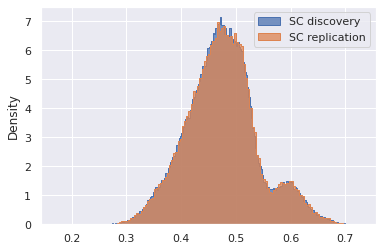

In [8]:
sns.histplot(sc.to_numpy().ravel(), label='SC discovery',
             stat='density', element='step', color=colors[0])
sns.histplot(sc_repl.to_numpy().ravel(), label='SC replication',
             stat='density', element='step', color=colors[1])
plt.legend()

plt.show()

## Regress out confounds

In [9]:
fc_confounds = (covariates.loc[fcon.index, ['sex', 'race', 'site_id']]
                .join(fc_extra['rsfmri_c_ngd_meanmotion'].rename('meanmotion')))
sc_confounds = (covariates.loc[scon.index, ['sex', 'race', 'site_id']]
                .join(sc_extra['dmri_dti_meanmotion'].rename('meanmotion')))

In [10]:
# WARNING: LONG

# import warnings
# import statsmodels.api as sm
# import mapply
# mapply.init(n_workers=4, chunk_size=1, progressbar=True)

# with warnings.catch_warnings():
#     warnings.simplefilter('ignore', sm.tools.sm_exceptions.ConvergenceWarning)
#     fc_control = fc.mapply(preprocess.confound_residuals, model=sm.MixedLM,
#                            regressors=fc_confounds.loc[fc.index, ['sex', 'race', 'meanmotion']],
#                            groups=fc_confounds.loc[fc.index, 'site_id'],
#                            method=['bfgs', 'cg', 'nm'])
#     sc_control = sc.mapply(preprocess.confound_residuals, model=sm.MixedLM,
#                            regressors=sc_confounds.loc[sc.index, ['sex', 'race', 'meanmotion']],
#                            groups=sc_confounds.loc[sc.index, 'site_id'],
#                            method=['bfgs', 'cg', 'nm'])

# fc_control.to_pickle('.cache/fc_control.pkl.gz')
# sc_control.to_pickle('.cache/sc_control.pkl.gz')
fc_control = pd.read_pickle('.cache/fc_control.pkl.gz')
sc_control = pd.read_pickle('.cache/sc_control.pkl.gz')

In [11]:
age = covariates.loc[fc_control.index, 'interview_age'] / 12
age_diff = (age.groupby(level=0)
            .diff().dropna().droplevel('eventname'))

dFC = (fc_control.groupby(level=0)
       .diff().dropna().droplevel('eventname')
       .divide(age_diff, axis=0))
FC = fc_control.loc[idx[dFC.index, abcd.EVENTS[0]], :].droplevel('eventname')
SC = sc_control.loc[idx[dFC.index, abcd.EVENTS[0]], :].droplevel('eventname')
X = FC.join(SC)

# Sparse CCA

In [12]:
from gemmr.estimators import SparseCCA
from sklearn.model_selection import GroupKFold

In [13]:
scca_SC = SparseCCA(n_components=SC.shape[1], scale=True, cv=GroupKFold(),
                    niter=200, verbose=True)

scca_SC.fit(SC, dFC, groups=family.loc[dFC.index])
joblib.dump(scca_SC, '.cache/scca_SC.joblib')

print('Score Correlations:', scca_SC.corrs_)

/home/kimsin98/miniconda3/envs/neuro/lib/python3.9/site-packages/gemmr/estimators/r_estimators.py:139: UserWarning: More than 1 mode selected: NOT TESTED
  warnings.warn('More than 1 mode selected: NOT TESTED')


[SparseCCA] penalties = [0.  0.2]
Score Correlations: [0.07101258 0.07529747 0.07138076 0.05831136 0.06353683 0.06987183
 0.09267609 0.06486649 0.06695603 0.080993   0.06400069 0.08938156
 0.07107209 0.06503493 0.06388681 0.05546204 0.06226206 0.05457132
 0.04952131 0.07924429 0.07770379 0.06856698 0.05583442 0.06521732
 0.08898771 0.0534181  0.07611091 0.05331076 0.04298087 0.05173023
 0.06688501 0.05943585 0.07777237 0.06855379 0.05301959 0.05180479
 0.04765638 0.05133891 0.04353921 0.06065624 0.06299906 0.06115923]
